<a href="https://colab.research.google.com/github/aiml40/engr521/blob/Alex_updates/engr521_group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#initialization - do not run

In [ ]:
# !git clone https://github.com/iikka-v/ML-NDT.git
# !cp -r ML-NDT/data/training /content/drive/MyDrive/engr521_dataset
# !cp -r ML-NDT/data/validation /content/drive/MyDrive/engr521_dataset

Cloning into 'ML-NDT'...
remote: Enumerating objects: 632, done.
remote: Total 632 (delta 0), reused 0 (delta 0), pack-reused 632 (from 1)
Receiving objects: 100% (632/632), 174.01 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (358/358), done.
Updating files: 100% (809/809), done.


In [ ]:
# Copy training folder to your Google Drive
# !cp -r /content/training /content/drive/MyDrive/2025_hw/engr521/training

In [ ]:
#show folder size for the engr521_dataset folder
# !du -sh /content/drive/MyDrive/engr521_dataset

2.5G	/content/drive/MyDrive/engr521_dataset


#Start

In [ ]:
#mount drive - run it one time per a session
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Exporting .jsons file from the dataset

In [ ]:
import pandas as pd
import json
import re

# Read the content of the file
with open('/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.jsons', 'r') as f:
    data = f.read()

# Prepare to decode multiple JSON objects from the string
decoder = json.JSONDecoder()
pos = 0
flaws_list = []

while pos < len(data):
    try:
        obj, next_pos = decoder.raw_decode(data, pos)
        pos = next_pos
        if "flaws" in obj:
            flaws_list.extend(obj["flaws"])
    except json.JSONDecodeError as e:
        print(f"Skipping invalid JSON at position {pos}: {e}")
        break  # or use pos += 1 to continue trying

# Convert to DataFrame
df = pd.DataFrame(flaws_list)
print(df.head())

                               location size        location_max  \
0   3654.237885462555-3899.339207048458  0.0  2198.7463370141086   
1                             4148-4317  1.6                4317   
2                             3387-3739  8.6                3739   
3  3999.6079295154186-4244.709251101322  0.0   2393.492441149644   
4  1604.2995594713657-2038.797356828194  4.0  1149.6302276388055   

        noise_flawsize              factor max_amplitude original_location  \
0                  0.0  0.8244211456795272          4050           558-580   
1  0.21340411413404115  0.6861373873395233          6028           763-790   
2  0.33668739882423104  0.7151297856390313         23474           642-698   
3                  0.0  0.5349937875370946          4050           527-549   
4    0.503911518748314  0.9734535488471048          7414           725-764   

  equivalent_flawsize noise_threshold        location_min  
0                 0.0             973  2060.5394244017934  
1 

In [ ]:
!pip install openpyxl  # Install openpyxl for Excel writing
import pandas as pd

# Assuming 'df' is your DataFrame
df.to_excel('flaws_data.xlsx', index=False, engine='openpyxl')

# Download the file (optional)
from google.colab import files
files.download('flaws_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#plotting 5 images from the dataser

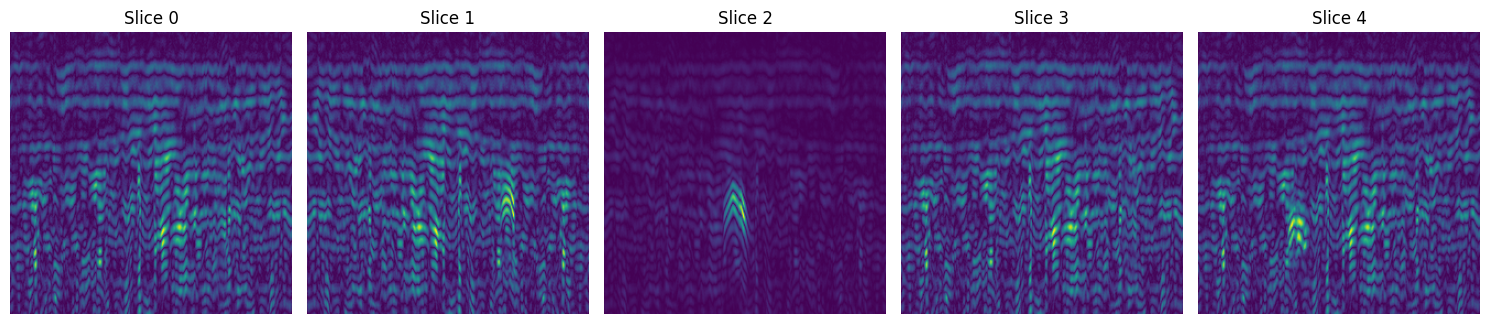

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Path to a sample .bins file
file_path = "/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.bins"

# Load raw data (uint16 format), then reshape to 3D volume
data = np.fromfile(file_path, dtype=np.uint16)
data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]

# Normalize data for visualization
data = data.astype(np.float32)
data -= data.mean()
data /= data.std() + 1e-5

# Plot a few slices (e.g., along the first axis)
plt.figure(figsize=(15, 5))
for i in range(5):  # Plot first 5 slices
    plt.subplot(1, 5, i + 1)
    plt.imshow(data[i], cmap='viridis')
    plt.title(f"Slice {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#saving a sample .bins batch of 100 images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load your DataFrame (assuming it's already loaded as df)
# Example: df = pd.read_csv("your_csv.csv")  <-- if needed

# Path to a sample .bins file
file_path = "/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.bins"

# Output image folder
output_folder = "/content/drive/MyDrive/engr521_dataset/Images"
os.makedirs(output_folder, exist_ok=True)

# Load raw data (uint16 format), then reshape to 3D volume
data = np.fromfile(file_path, dtype=np.uint16)
data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]

# Normalize data for visualization
data = data.astype(np.float32)
data -= data.mean()
data /= data.std() + 1e-5

# Save first 5 slices as PNGs with custom names
for i in range(100):
    if i >= len(df):
        print(f"Skipping slice {i}: no corresponding row in DataFrame.")
        continue

    size_value = df.iloc[i]["size"]
    filename = f"{i:04d}_{size_value}.png"
    filepath = os.path.join(output_folder, filename)

    plt.imsave(filepath, data[i], cmap='viridis')

print("Images saved successfully.")


Images saved successfully.


#Convert to Pickles

In [ ]:
#use pickles library to collect images from .bins file and .labels file
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

# Path to .bins file and .labels file
path = "/content/drive/MyDrive/engr521_dataset/validation/"
# iterate over directory and create a pickle file

all_data = []  # List to store data from all .bins files
all_labels = [] # List to store labels from all .labels files

for filename in os.listdir(path):
  #read images from all .bins files. There are 100 images 256x256 in each bins file

  if filename.endswith(".bins"):
    # Load raw data (uint16 format), then reshape to 3D volume
    data = np.fromfile(path+filename, dtype=np.uint16)
    data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]
    all_data.append(data)  # Append data to the list
    #take labels from the same file name which ends with .labels instead of .bins
    label_filename = filename[:-5] + ".labels"
    labels = np.loadtxt(path+label_filename)
    all_labels.append(labels)  # Append labels to the list

path = "/content/drive/MyDrive/engr521_dataset/training/"

for filename in os.listdir(path):
  #read images from all .bins files. There are 100 images 256x256 in each bins file

  if filename.endswith(".labels"):
    # Load raw data (uint16 format), then reshape to 3D volume
    labels = np.loadtxt(path+filename)
    all_labels.append(labels)  # Append labels to the list
    n=labels.shape[0]

    #take labels from the same file name which ends with .labels instead of .bins
    data_filename = filename[:-7] + ".bins"
    data = np.fromfile(path+data_filename, dtype=np.uint16)
    data = data.reshape((n, 256, 256))  # Shape: [depth, height, width]
    all_data.append(data)  # Append data to the list

# Concatenate along the first axis (depth) to maintain [depth, height, width]
all_data = np.concatenate(all_data, axis=0)

# Concatenate labels to form a matrix (assuming labels are 1D arrays)
all_labels = np.vstack(all_labels)  # Use vstack for vertical stacking

print(all_data.shape)
print(all_labels.shape)
#create a pickle .pkl file with the above images and labels
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "wb") as f:
  pickle.dump((all_data, all_labels), f)
f.close()

#lets see what is in .pkl file
# with open(path+"validation.pkl", "rb") as f:
#   data, labels = pickle.load(f)
# print(data.shape)
# print(labels.shape)
# print(len(labels))
# for i in range(len(labels)):
#   if labels[i,1]>6:
#     plt.imshow(data[i], cmap='viridis')
#     plt.show()


#plot first 5 images along with labels data from pickle
# import matplotlib.pyplot as plt
# for i in range(5):
#   plt.subplot(5, 1, i + 1)
#   plt.imshow(data[i], cmap='viridis')
#   plt.title(f"Slice {i}, Label: {labels[i]}")
#   plt.axis('off')
# plt.show()

(20010, 256, 256)
(20010, 2)


#Read pickle to data, labels

In [ ]:
#open a single random image from pickle file
#pickle path "/content/drive/MyDrive/engr521_dataset/dataset.pkl"
import pickle
# import numpy as np
# import matplotlib.pyplot as plt

with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "rb") as f:
  data, labels = pickle.load(f)
print(data.shape)
print(labels.shape)
#plot an image from pickle and its label
# i = np.random.randint(0, len(labels))
# plt.imshow(data[i][0], cmap='viridis')
# plt.title(f"Slice {i}, Label: {labels[i]}")
# plt.axis('off')
# plt.show()


(20010, 1, 256, 256)
(20010, 2)


In [ ]:
print(data.shape)
print(labels.shape)

(20010, 1, 256, 256)
(20010, 2)


In [ ]:
import pickle
import numpy as np

# Load the original data
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "rb") as f:
    data, labels = pickle.load(f)

# Reshape data to (N, 1, 256, 256)
if data.ndim == 3:
    data = data[:, np.newaxis, :, :]  # add channel dimension

# Save back to the same (or new) pickle file
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "wb") as f:
    pickle.dump((data, labels), f)


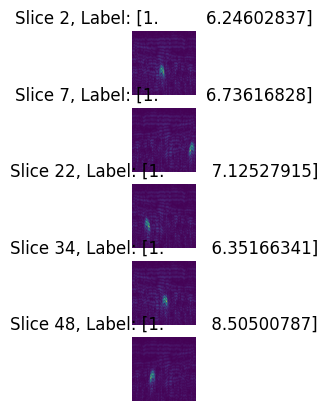

In [ ]:
#plot 5 first images from data where labels[i,1]>6.0
import matplotlib.pyplot as plt
import numpy as np
i=0
for j in range(len(labels)):
  if labels[j,1]>6.0:
    plt.subplot(5, 1, i + 1)
    plt.imshow(data[j], cmap='viridis')
    plt.title(f"Slice {j}, Label: {labels[j]}")
    plt.axis('off')
    i+=1
    if i==5:
      break
plt.show()






#Keras code with Pickle

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

'''
    This code trains a convolutional network to find flaws in
    ultrasonic data. See https://arxiv.org/abs/1903.11399 for details.
'''

from __future__ import print_function
import keras
from keras import backend as K
from keras import Input, layers
from keras import Model
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.interactive(True)
import pickle
import uuid

w, h = 256, 256                       # initial data size
window = 7                             # window for the first max-pool operation

run_uuid = uuid.uuid4()                # unique identifier is generated for each run

# Load the dataset from the pickle file
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "rb") as f:
    data, labels = pickle.load(f)

# Ensure data is in the correct shape
data = data.astype('float32')
data -= data.mean()
data /= data.std() + 0.00001          # avoid division by zero
data = np.reshape(data, (-1, 256, 256, 1), 'C')

# Extract labels for binary classification
# Assuming labels are in shape (num_samples, 2), take the first column for binary classification
labels = labels[:, 0]  # Use the first column for binary classification

# Split the dataset into training and validation sets
num_validation_samples = 100
val_xs = data[:num_validation_samples]
val_ys = labels[:num_validation_samples]

train_xs = data[num_validation_samples:]
train_ys = labels[num_validation_samples:]

# Define the data generator
def data_generator(batch_size=10):
    rows = train_xs.shape[0]
    cursor = 0
    while True:
        start = cursor
        cursor += batch_size
        if cursor > rows:
            cursor = 0
        yield (train_xs[start:cursor, :, :, :], train_ys[start:cursor])

input_tensor = Input(shape=(w, h, 1))

# Start with max-pool to envelop the UT-data
ib = layers.MaxPooling2D(pool_size=(window, 1), padding='valid')(input_tensor)

# Build the network
cb = layers.Conv2D(96, 3, padding='same', activation='relu')(ib)
cb = layers.Conv2D(64, 3, padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D((2, 8), padding='same')(cb)

cb = layers.Conv2D(48, 3, padding='same', activation='relu')(cb)
cb = layers.Conv2D(32, 3, padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D((3, 4), padding='same')(cb)
cb = layers.Flatten()(cb)
cb = layers.Dense(14, activation='relu', name='RNN')(cb)
iscrack = layers.Dense(1, activation='sigmoid', name='output')(cb)

model = Model(input_tensor, iscrack)
opt = keras.optimizers.RMSprop(learning_rate=0.0001, clipnorm=1.)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Callbacks for training
callbacks = [
    keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1),
    keras.callbacks.ModelCheckpoint('modelcpnt' + str(run_uuid) + '.keras', monitor='val_loss', verbose=1, save_best_only=True)
]

# Train the model
model.fit(data_generator(100), epochs=100, validation_data=(val_xs, val_ys), steps_per_epoch=len(train_xs) // 100, callbacks=callbacks)

# Predictions and plotting
predictions = model.predict(val_xs)

# Reshape val_ys to be two-dimensional for concatenation
val_ys_reshaped = val_ys.reshape(-1, 1)  # Reshape to (num_samples, 1)

# Concatenate the reshaped val_ys with predictions
res = np.concatenate((val_ys_reshaped, predictions), axis=-1)

# Plotting the results
plt.plot(res[:, 0], res[:, 1], 'bo')  # Adjusted to use the correct indices
plt.show()
print(res)
np.savetxt('results_pickle.txt', res)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 256, 96)    │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 256, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 32, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 32, 32)     │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN (Dense)                     │ (None, 14)             │        21,518 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,405 (466.43 KB)

 Trainable params: 119,405 (466.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.6867 - loss: 0.5382
Epoch 1: val_loss improved from inf to 0.27460, saving model to modelcpnteeb453f3-ecc9-40cb-a5cd-d661b12d2cf3.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - acc: 0.6872 - loss: 0.5377 - val_acc: 0.9600 - val_loss: 0.2746
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9047 - loss: 0.2683
Epoch 2: val_loss improved from 0.27460 to 0.12502, saving model to modelcpnteeb453f3-ecc9-40cb-a5cd-d661b12d2cf3.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - acc: 0.9048 - loss: 0.2681 - val_acc: 0.9500 - val_loss: 0.1250
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9309 - loss: 0.1915
Epoch 3: val_loss improved from 0.12502 to 0.10534, saving model to modelcpnteeb453f3-ecc9-40cb-a5cd-d661b12d2cf3.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - acc: 0.9309 - loss: 0.1915 - val_acc: 0.9600 - val_loss: 0.1053
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9526

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

#Intitial training code with slight modifications (12 minutes training)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 36, 256, 96)    │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 256, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 32, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 32, 32)     │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN (Dense)                     │ (None, 14)             │        21,518 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,405 (466.43 KB)

 Trainable params: 119,405 (466.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - acc: 0.5871 - loss: 0.6330
Epoch 1: val_loss improved from inf to 0.57592, saving model to modelcpntd39da9d7-6ca9-45d6-bd98-2c582357a869.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - acc: 0.5876 - loss: 0.6325 - val_acc: 0.5700 - val_loss: 0.5759
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.7653 - loss: 0.5076
Epoch 2: val_loss improved from 0.57592 to 0.48372, saving model to modelcpntd39da9d7-6ca9-45d6-bd98-2c582357a869.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.7658 - loss: 0.5072 - val_acc: 0.7500 - val_loss: 0.4837
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - acc: 0.8406 - loss: 0.4144
Epoch 3: val_loss improved from 0.48372 to 0.36567, saving model to modelcpntd39da9d7-6ca9-45d6-bd98-2c582357a869.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - acc: 0.8410 - loss: 0.4140 - val_acc: 0.8600 - val_loss: 0.3657
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - acc: 0.9066 - loss: 0.311

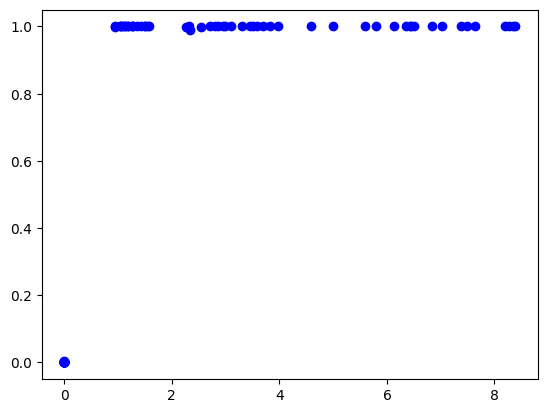

[[0.0000000e+00 0.0000000e+00 4.5556990e-05]
 [0.0000000e+00 0.0000000e+00 1.5671075e-04]
 [0.0000000e+00 0.0000000e+00 5.3301358e-07]
 [1.0000000e+00 1.4357594e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.1671324e-06]
 [0.0000000e+00 0.0000000e+00 8.3995374e-06]
 [0.0000000e+00 0.0000000e+00 5.4956931e-03]
 [1.0000000e+00 3.9754386e+00 1.0000000e+00]
 [1.0000000e+00 8.3844995e+00 1.0000000e+00]
 [1.0000000e+00 3.8163941e+00 1.0000000e+00]
 [1.0000000e+00 6.8416162e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 7.4109585e-07]
 [0.0000000e+00 0.0000000e+00 3.7620264e-06]
 [0.0000000e+00 0.0000000e+00 1.5991193e-04]
 [1.0000000e+00 9.4440591e-01 9.9950480e-01]
 [1.0000000e+00 7.4808564e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.6337827e-07]
 [1.0000000e+00 2.3222325e+00 9.9995673e-01]
 [1.0000000e+00 3.3124421e+00 1.0000000e+00]
 [1.0000000e+00 5.8017273e+00 1.0000000e+00]
 [1.0000000e+00 6.1342368e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.6381231e-05]
 [0.000000

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

'''
    This code trains a convolutional network to find flaws in
    ultrasonic data. See https://arxiv.org/abs/1903.11399 for details.
'''

from __future__ import print_function
import keras
from keras import backend as K
from keras import Input, layers
from keras import Model

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.interactive(True)

from os import listdir
from os.path import isfile, join
import uuid
import time


w,h = 256,256                       # initial data size
window = 7                          # window for the first max-pool operation

run_uuid = uuid.uuid4()             #unique identifier is generated for each run

path = "/content/drive/MyDrive/engr521_dataset/training/"          #training data path
vpath = "/content/drive/MyDrive/engr521_dataset/validation/"       #validation data path

'''     The data_generator reads raw binary UT data from the pre-processed files
        and preconditions it for ML training. '''
def data_generator( batch_size = 10):
    input_files = [f for f in listdir(path) if isfile(join( path,f)) and f.endswith('.bins') ]
    np.random.shuffle(input_files)          # we'll take random set from available data files
    input_files = input_files[0:100]        # limit to 100 files per epoch
    xs = np.empty( (0), dtype='float32')    #  input data
    ys = np.empty((0,2), dtype='float32')   #  label data
    for i in input_files:
        bxs = np.fromfile(path+i, dtype=np.uint16).astype('float32')
        bxs -= bxs.mean()
        bxs /= bxs.std() +0.00001           #avoid division by zero
        xs = np.concatenate((xs,bxs))
        bys = np.loadtxt(path + i[:-5] +'.labels')
        ys = np.concatenate((ys,bys) )

    xs = np.reshape(xs, (-1,256,256,1), 'C')

    rows = xs.shape[0]
    cursor = 0
    while True:
        start = cursor
        cursor += batch_size
        if(cursor > rows):
            cursor = 0
        bxs = xs[start:cursor,:,:,:]
        bys = ys[start:cursor,0]
        yield( (xs[start:cursor,:,:,:], ys[start:cursor,0]) )


input_tensor = Input(shape=(w,h,1))

# start with max-pool to envelop the UT-data
ib = layers.MaxPooling2D(pool_size=(window,1),  padding='valid' )(input_tensor) # MaxPooling1D would work, but we may want to pool adjacent A-scans in the future

#build the network
cb = layers.Conv2D(96,3,padding='same', activation='relu')(ib)
cb = layers.Conv2D(64,3,padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D( (2,8), padding='same')(cb)

cb = layers.Conv2D(48,3,padding='same', activation='relu')(cb)
cb = layers.Conv2D(32,3,padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D( (3,4), padding='same' )(cb)
cb = layers.Flatten()(cb)
cb = layers.Dense(14, activation='relu', name='RNN')(cb)
iscrack = layers.Dense(1, activation='sigmoid', name='output')(cb)


model = Model(input_tensor, iscrack)
#it was 'lr' instead of 'learning_rate' in the original code
opt = keras.optimizers.RMSprop(learning_rate=0.0001, clipnorm=1.)
model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=['acc'])
model.summary()

#moved this section from below to make rxs variable available to debugCallBack class
test_uuid = "FA4DC2D8-C0D9-4ECB-A319-70F156E3AF31"
rxs = np.fromfile(vpath+test_uuid+".bins", dtype=np.uint16 ).astype('float32')
rxs -= rxs.mean()
rxs /= rxs.std()+0.0001
rxs = np.reshape( rxs, (-1,256,256,1), 'C')
rys = np.loadtxt(vpath+test_uuid+".labels", dtype=np.float32)

# class DebugCallback(keras.callbacks.Callback):
# #    def on_batch_end(self, batch, logs={}):
#     def on_epoch_end(self, epoch, logs={} ):
#         predictions = model.predict(rxs)
#         res = np.concatenate((rys, predictions), -1)
#         plt.plot(res[:, 1], res[:, 2], 'bo')
#         plt.show()
        #plt.savefig("out.png")

# debug = DebugCallback()

# callbacks = [  keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1)
#              , keras.callbacks.ModelCheckpoint( 'modelcpnt'+str(run_uuid)+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#              , debug ]

# callbacks = [  keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1)
#              , keras.callbacks.ModelCheckpoint( 'modelcpnt'+str(run_uuid)+'.keras', monitor='val_loss', verbose=1, save_best_only=True) # Changed .hdf5 to .keras
#              , debug ]
callbacks = [
    keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1),
    keras.callbacks.ModelCheckpoint('modelcpnt'+str(run_uuid)+'.keras', monitor='val_loss', verbose=1, save_best_only=True)
]

# Generate data for validation outside the generator function
validation_generator = data_generator(100)  # Create a generator instance
validation_data = next(validation_generator)  # Get one batch of data for validation
# Unpack the validation data
val_xs, val_ys = validation_data

#model.fit_generator(data_generator(100),epochs=100,validation_data= (xs,ys[:,0]),steps_per_epoch=60,callbacks=callbacks)
# Replace 'model.fit_generator' with 'model.fit':

#model.fit(data_generator(100), epochs=100, validation_data=(xs, ys[:, 0]), steps_per_epoch=60, callbacks=callbacks)
#updated model.fit statement
model.fit(data_generator(100), epochs=100, validation_data=(val_xs, val_ys), steps_per_epoch=60, callbacks=callbacks)


#commented 'cd' out
#cd
predictions = model.predict(rxs)
res = np.concatenate( (rys,predictions), -1 )
plt.plot(res[:,1], res[:,2], 'bo')
plt.show()
print( res )
np.savetxt('results.txt', res)

#Wavelet transform

In [ ]:
!pip install PyWavelets

##Test on 4 samples

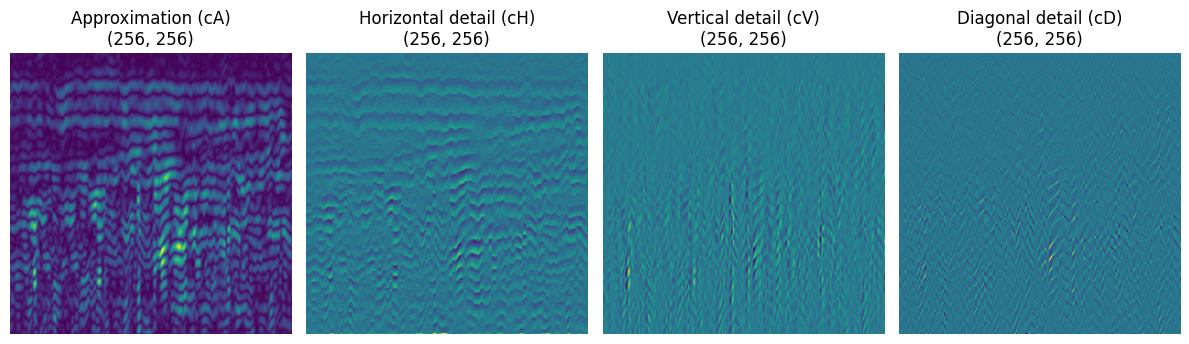

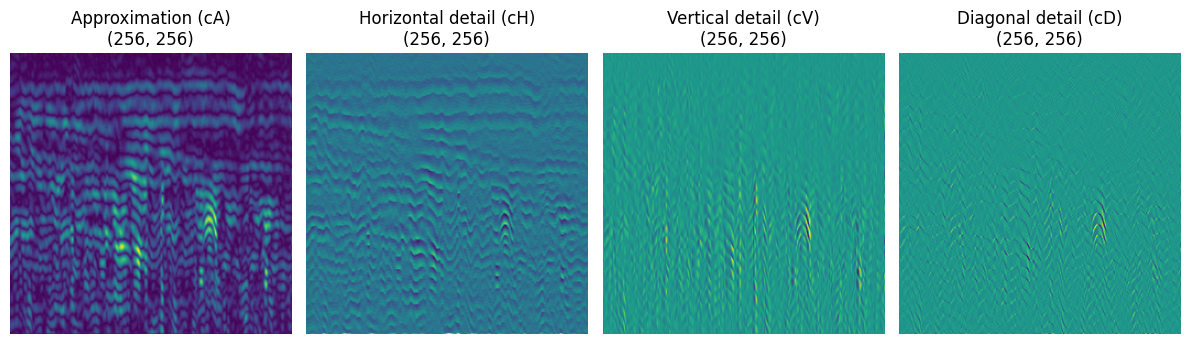

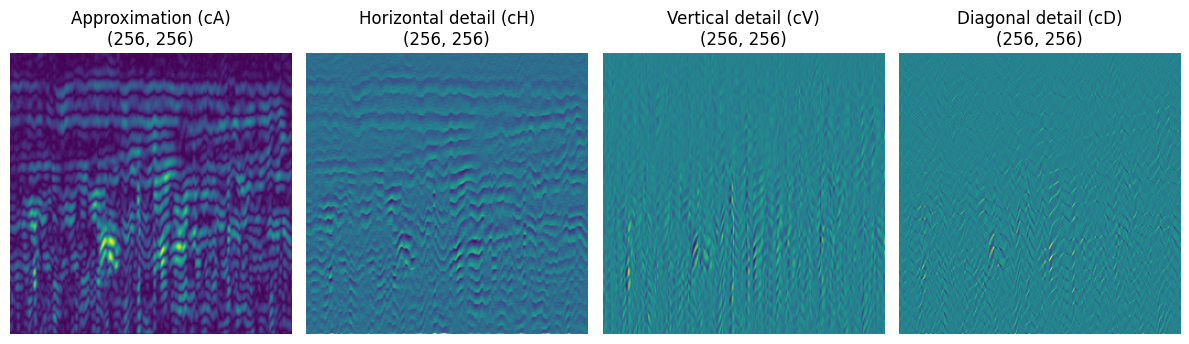

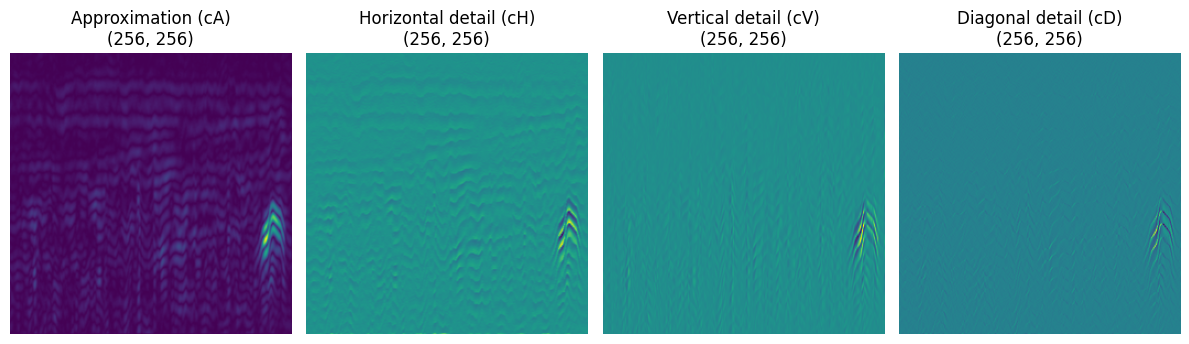

In [ ]:
import pywt
import matplotlib.pyplot as plt
#data_wvl = np.zeros((len(labels), 1, 256, 256), dtype=np.float32)
wavelet = 'haar'

for j in [0,1,4,7]:
    # pull out a (256×256) array directly
    image = data[j, 0, :, :]

    # 1) decompose with the non‐decimating SWT
    coeffs_swt = pywt.swt2(image,
                           wavelet=wavelet,
                           level=1,
                           )
    # coeffs_swt is a list of length=level; each entry is (cA, (cH,cV,cD))
    cA, (cH, cV, cD) = coeffs_swt[0]

    # 2) (optional) boost the detail coefficients
    boost = 1.5
    coeffs_swt_boost = [
        (cA, (boost*cH, boost*cV, boost*cD))
    ]

    # 3) reconstruct with ISWT (uses the same wavelet)
    sharpened = pywt.iswt2(coeffs_swt_boost,
                           wavelet=wavelet,
                           )

    # 4) plot – all will be 256×256
    titles = ['Approximation (cA)', 'Horizontal detail (cH)',
              'Vertical detail (cV)',    'Diagonal detail (cD)']
    components = [cA, cH, cV, cD]

    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for ax, comp, title in zip(axes, components, titles):
        ax.imshow(comp, cmap='viridis', vmin=comp.min(), vmax=comp.max())
        ax.set_title(f"{title}\n{comp.shape}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


## Run wavelet transform on the whole dataset and write to pkl

In [ ]:
import pywt
import numpy as np
data_wvl = np.zeros_like(data)
wavelet = 'haar'

for j in range(len(labels)):
    # pull out a (256×256) array directly
    image = data[j, 0, :, :]

    # 1) decompose with the non‐decimating SWT
    coeffs_swt = pywt.swt2(image,
                           wavelet=wavelet,
                           level=1,
                           )
    # coeffs_swt is a list of length=level; each entry is (cA, (cH,cV,cD))
    cA, (cH, cV, cD) = coeffs_swt[0]

    # 2) (optional) boost the detail coefficients
    boost = 1.5
    coeffs_swt_boost = [
        (cA, (boost*cH, boost*cV, boost*cD))
    ]

    # 3) reconstruct with ISWT (uses the same wavelet)
    sharpened = pywt.iswt2(coeffs_swt_boost,
                           wavelet=wavelet,
                           )

    # 4) write to pickle
    data_wvl[j, 0, :, :]=sharpened

# Save back to a new pickle file
import pickle
with open("/content/drive/MyDrive/engr521_dataset/dataset_Haar_Full.pkl", "wb") as f:
    pickle.dump((data_wvl, labels), f)


In [ ]:
print(data_wvl.shape)

(20010, 1, 256, 256)


In [ ]:
wavelet = pywt.Wavelet('coif5')
print(wavelet)

Wavelet coif5
  Family name:    Coiflets
  Short name:     coif
  Filters length: 30
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


#Create a Pickle with CD Haar Wavelet transform

In [ ]:
print(cD.shape)

(256, 256)


In [ ]:
# Reshape data to (N, 1, 256, 256)
data_cD = np.zeros((len(labels), 1, 128, 128), dtype=np.float32)
for i in range(len(labels[0])):
  image=data[i][0]
  # Apply 2D Discrete Wavelet Transform (DWT)
  coeffs2 = pywt.dwt2(image, 'db1')  # 'db1' is Haar wavelet
  # coeffs2 = pywt.dwt2(image, 'bior3.3')
  _, (_ ,_, cD) = coeffs2  # Approximation, Horizontal, Vertical, Diagonal
  data_cD[i][0]=cD

# Save back to the same (or new) pickle file
with open("/content/drive/MyDrive/engr521_dataset/dataset_Haar_cD.pkl", "wb") as f:
    pickle.dump((data_cD, labels), f)

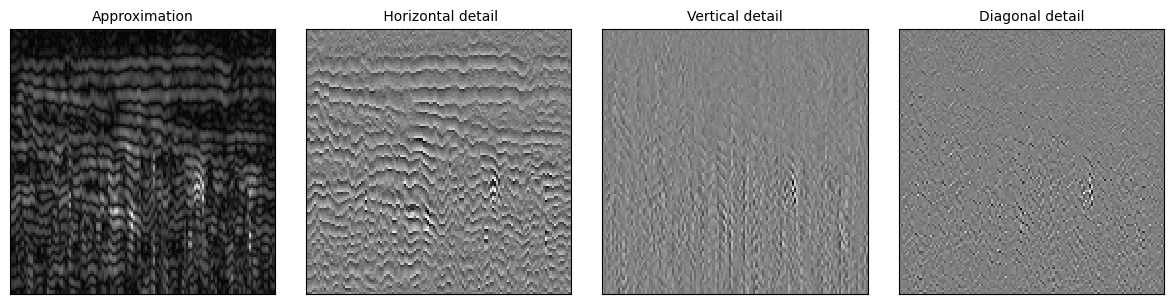

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(image, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

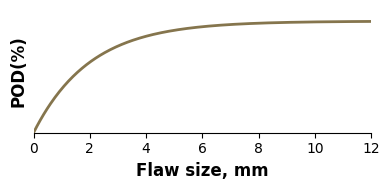

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example POD curve data
flaw_size = np.linspace(0, 12, 300)
pod = 100 * (1 - np.exp(-flaw_size / 2))  # Example S-curve

# Create the plot
fig, ax = plt.subplots(figsize=(4, 2))  # Wide and short figure

# Plot the curve
ax.plot(flaw_size, pod, linewidth=2, color='#85754d')  # Orange-like color

# Axis labels
ax.set_xlabel("Flaw size, mm", fontsize=12, fontweight='bold')
ax.set_ylabel("POD(%)", fontsize=12, fontweight='bold')

# Clean up the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Remove vertical axis line and ticks
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])

# Axis limits and ticks
ax.set_xlim(0, 12)
ax.set_ylim(0, 110)
ax.set_xticks(np.arange(0, 13, 2))
#ax.set_yticks(np.arange(0, 110, 20))
ax.tick_params(axis='both', which='major', labelsize=10)

# Layout
plt.tight_layout()
plt.show()


In [ ]:
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# 1) Load and preprocess
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "rb") as f:
    data_np, labels_np = pickle.load(f)

# Keras used labels[:,0]
labels_bin = labels_np[:, 0].astype(np.float32)

# data_np is (20010,1,256,256) already in NCHW
data = data_np.astype(np.float32)
data = (data - data.mean()) / (data.std() + 1e-5)

# to torch
data_t = torch.from_numpy(data)              # shape (N,1,256,256)
labels_t = torch.from_numpy(labels_bin)      # shape (N,)

# reshape labels to (N,1) for BCELoss
labels_t = labels_t.unsqueeze(1)

# 2) Split into train / val
num_val = 100
train_data = data_t[num_val:]
train_labels = labels_t[num_val:]
val_data   = data_t[:num_val]
val_labels = labels_t[:num_val]

train_ds = TensorDataset(train_data, train_labels)
val_ds   = TensorDataset(val_data,   val_labels)

train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=100)


# 3) Model definition
class UTNet(nn.Module):
    def __init__(self):
        super().__init__()
        window = 7
        self.pool1 = nn.MaxPool2d((window,1), stride=(window,1))
        self.conv1 = nn.Conv2d(  1, 96, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d( 96, 64, kernel_size=3, padding=1)
        # “same” pooling: approximate with padding=(0,4)
        self.pool2 = nn.MaxPool2d((2,8), stride=(2,8), padding=(0,4))
        self.conv3 = nn.Conv2d( 64, 48, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d( 48, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((3,4), stride=(3,4), padding=(1,1))
        # compute flatten dim: after pool3 you get (batch,32,6,8)
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(32*6*8, 14)
        self.fc2     = nn.Linear(14, 1)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = UTNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, alpha=0.9)

# 4) Training + validation loop
num_epochs = 10
for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    running_correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        running_correct += ((preds >= 0.5) == yb).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_correct / len(train_loader.dataset)

    # --- val ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    all_true, all_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += ((preds >= 0.5) == yb).sum().item()
            all_true .append(yb.cpu().numpy())
            all_pred .append(preds.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc  = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:3d}/{num_epochs} "
          f"— train_loss: {epoch_loss:.4f}  train_acc: {epoch_acc:.4f}  "
          f"val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}")

# 5) Gather and plot results
true_arr = np.vstack(all_true)
pred_arr = np.vstack(all_pred)
res = np.concatenate([true_arr, pred_arr], axis=1)

plt.plot(res[:,0], res[:,1], 'bo')
plt.xlabel("True label")
plt.ylabel("Predicted probability")
plt.title("Validation Results")
plt.show()

np.savetxt('results_pytorch.txt', res)


Epoch   1/100 — train_loss: 0.4927  train_acc: 0.7357  val_loss: 0.3468  val_acc: 0.9400
Epoch   2/100 — train_loss: 0.3550  train_acc: 0.8695  val_loss: 0.7848  val_acc: 0.5700
Epoch   3/100 — train_loss: 0.3203  train_acc: 0.9015  val_loss: 0.3262  val_acc: 0.9300
Epoch   4/100 — train_loss: 0.2956  train_acc: 0.9223  val_loss: 0.3415  val_acc: 0.8100
Epoch   5/100 — train_loss: 0.2749  train_acc: 0.9402  val_loss: 0.2727  val_acc: 0.9600
Epoch   6/100 — train_loss: 0.2567  train_acc: 0.9613  val_loss: 0.2968  val_acc: 0.9100
Epoch   7/100 — train_loss: 0.2419  train_acc: 0.9747  val_loss: 0.2435  val_acc: 0.9900
Epoch   8/100 — train_loss: 0.2297  train_acc: 0.9821  val_loss: 0.3720  val_acc: 0.6800
Epoch   9/100 — train_loss: 0.2221  train_acc: 0.9836  val_loss: 0.2265  val_acc: 1.0000
Epoch  10/100 — train_loss: 0.2128  train_acc: 0.9899  val_loss: 0.3171  val_acc: 0.7300
Epoch  11/100 — train_loss: 0.2063  train_acc: 0.9924  val_loss: 0.2140  val_acc: 1.0000
Epoch  12/100 — train